In [1]:
#Functions to be added
import pickle
import glob
import cv2

def get_num_classes(data_dir):
    """
    Get the number of classes.
    :param data_dir: str - data directory
    :return: int - number of classes
    """
    mode = 'training' # arbitrary
    loc = "{}/{}".format(data_dir, mode)
    with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
        data = pickle.load(f)

    modes = list(data.keys())

    assert glob.glob(data_dir), "Check directory."
    assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
    i = 0  # Arbitrarily chosen
    return len(data[modes[i]][i][-1])

def generate_img_label_from_folder(data_dir, mode, batch_size):
    """

    """
    loc = "{}/{}".format(data_dir, mode)
    while True:
        with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
            data = pickle.load(f)

        modes = list(data.keys())
        del modes[-1]

        assert mode in modes, "'{}' not a valid mode (must be one of {})".format(mode, str(modes))
        assert glob.glob(loc), "Check directory."
        assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
        for idx in range(0, len(data[mode]), batch_size):
            start = idx
            end = idx + batch_size
            images, labels = read_n_images(data[mode], start, end, loc)
            yield (images/255, np.array(labels))

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
from shared.autoencoderHelpers import read_n_images, generate_img_from_folder, get_input_shape, get_num_examples, plot_history, get_images, bgr2rgb, plot_reconstruction

In [3]:
DATA_DIR = '../data'
autoencoder = tf.keras.models.load_model('../models/autoencoder/twoClassTestUntrained/model') 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

In [6]:
# lets we if we can just train a classifier work
inputLayer = Input(shape=(200,200,3), name='input_layer')
x = Conv2D(8,(5,5),activation='relu',padding='same')(inputLayer)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(4,(1,1),activation='relu')(x)
x = Flatten()(x)
x = Dense(500,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(500,activation='relu')(x)
x = Dropout(rate=0.5)(x)
outputLayer = Dense(2,activation='sigmoid')(x)
classifier = Model(inputs=inputLayer,outputs=outputLayer)
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 200, 8)       608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 8)       584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 8)         0         
__________

In [117]:
layer_names = [autoencoder.layers[i].name for i in range(7)]
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[6].output)
# for layer in encoder.layers:
#     layer.trainable = False
    
flat = Flatten()(encoder.output)

x = Dense(1024, activation=tf.nn.relu, name='fc_1')(flat)
x = Dense(256, activation=tf.nn.relu, name='fc_2')(x)
x = Dropout(rate=0.5, name='dropout')(x)
x = Dense(256, activation=tf.nn.relu, name='fc_3')(x)
output_layer = Dense(5, activation=tf.nn.sigmoid, name='output_layer')(x)

classifier = Model(inputs=encoder.inputs, outputs=output_layer)



In [118]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

In [7]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
batchSize = 8
epochs = 30

BATCH_SIZE_TRAIN = 8
NUM_SAMPLES_TRAIN = get_num_examples(DATA_DIR, 'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 8
NUM_SAMPLES_VAL = get_num_examples(DATA_DIR, 'validation')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 30
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = classifier.fit_generator(generate_img_label_from_folder(DATA_DIR, 'training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=generate_img_label_from_folder(DATA_DIR, 'validation', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)


Epoch 1/30
65/65 [==============================] - 20s 313ms/step - loss: 0.6209 - acc: 0.6154 - val_loss: 0.5601 - val_acc: 0.7457
Epoch 2/30
65/65 [==============================] - 21s 319ms/step - loss: 0.5538 - acc: 0.7577 - val_loss: 0.4905 - val_acc: 0.7630
Epoch 3/30
65/65 [==============================] - 21s 327ms/step - loss: 0.4888 - acc: 0.8019 - val_loss: 0.4159 - val_acc: 0.8382
Epoch 4/30
65/65 [==============================] - 22s 332ms/step - loss: 0.4091 - acc: 0.8404 - val_loss: 0.3502 - val_acc: 0.8728
Epoch 5/30
65/65 [==============================] - 21s 328ms/step - loss: 0.3827 - acc: 0.8481 - val_loss: 0.4448 - val_acc: 0.8208
Epoch 6/30
65/65 [==============================] - 21s 325ms/step - loss: 0.2997 - acc: 0.8885 - val_loss: 0.3971 - val_acc: 0.8728
Epoch 7/30
65/65 [==============================] - 21s 330ms/step - loss: 0.2646 - acc: 0.8865 - val_loss: 0.4578 - val_acc: 0.8555
Epoch 8/30
65/65 [==============================] - 21s 322ms/step - 

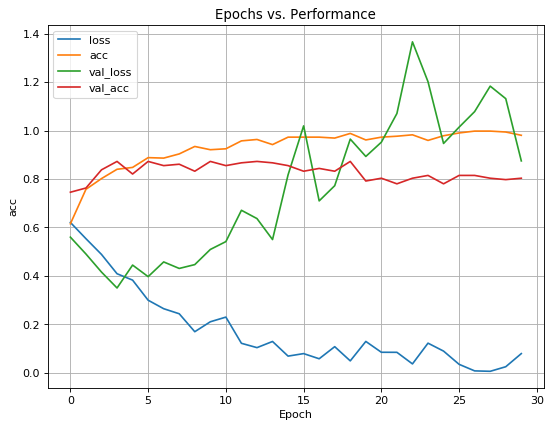

In [9]:
plot_history(history)

In [50]:
weights = classifier.layers[1].get_weights()[0]
print(weights.shape)

i = weights[:,:,:,1]
p = np.array(i)
print(p)

(5, 5, 3, 8)
[[[-0.04062018 -0.01043048 -0.01360338]
  [-0.09977818 -0.02016452  0.02263547]
  [-0.01880049 -0.11971757  0.02212365]
  [-0.09797697  0.03430111 -0.02196601]
  [-0.02315307  0.11929844  0.1153881 ]]

 [[-0.14811748 -0.04245551 -0.04759424]
  [ 0.11552688 -0.10451786 -0.02910373]
  [-0.08356053  0.12648763 -0.09687892]
  [ 0.0199993   0.00547719  0.0402925 ]
  [ 0.00855507 -0.08269147  0.10686585]]

 [[ 0.04003436 -0.14411427 -0.02034143]
  [-0.03090072 -0.15113752  0.05598361]
  [-0.00943855  0.03104147  0.10258144]
  [-0.16878645 -0.04616641  0.012081  ]
  [ 0.07838139  0.09344555  0.04090764]]

 [[-0.05392553 -0.10234417 -0.0563415 ]
  [ 0.11196762 -0.10843692 -0.14586599]
  [-0.05456867  0.05442654 -0.07357349]
  [-0.12363835 -0.1177844  -0.13764396]
  [-0.12628508  0.03994126  0.03402099]]

 [[ 0.05189904  0.13403074  0.09803297]
  [ 0.1384766   0.0035912  -0.14013875]
  [ 0.09351029 -0.04279587  0.1426035 ]
  [ 0.05869128 -0.14089067 -0.13622901]
  [-0.14230137  0.0